# Fit the model developed in (LINK NOTEBOOK) and make Kaggle submission 

### Issues preventing full incorporation into one pipeline
- current structure of `feature_engineer_aggregate_individuals` needs to be run after the other feature engineering, but within a pipeline cannot work on the np array produced by the feature_extraction `FeatureUnion`
- betweeen feature engineering and other transformations, want to subset to heads of household (otherwise these transformers will use non-heads in fitting) 
- if I'm using early stopping, then I need to split data into train and validation sets (which would need to happen after the transformations...)

### Why that matters
- Hyperopt tuning on entire process
- Using `pickle` to save fitted model should it need to be used in production

## Things I've learned: 
- always be precise in the problem you're trying to solve. For example, when figuring out how to best use kfold for xgboost early stopping validation, should I be doing this as a custom estimator, or doing the whole pipeline for the subset of the data? (isn't this just bagging?) 

# READ
- http://dnc1994.com/2016/05/rank-10-percent-in-first-kaggle-competition-en/![image.png](attachment:image.png)
- https://medium.com/@rrfd/boosting-bagging-and-stacking-ensemble-methods-with-sklearn-and-mlens-a455c0c982de
- http://scikit-learn.org/stable/modules/ensemble.html
- https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

# Questions
- should I be bagging the XGBoost classifier, or stacking multiple? 
- using `BaggingClassifier` can you implement early stopping with oob? 
- should you bag AND stack? 


### Things I'm figuring out
- how/if to use early stopping within kfold cross validation (rather than just one validation set). **if I do this please please show your work in a notebook**
    - WHAT DO I WANT? I want a pipeline step that runs xgboost with early stopping  on a kfold and uses soft voting to combine, right? 
    - OR do I want BAGGING? (e.g. `BaggingClassifier`) - the oob could theoretically be used for early stopping, right? 
    - OR, do I want a regular pipeline that is then fit e.g. 5 times for a kfold with 5 folds, then combine the predictions. This seems slower, but avoids leakage etc and leverages the pipeline tools (e.g. using the different folds for every pipeline step). BUT then it wouldn't actually help do better predictions when pipeline.fit is called (and hence doesn't actually help hyperparameter tuning). ISN'T THIS JUST STACKING (http://dnc1994.com/2016/05/rank-10-percent-in-first-kaggle-competition-en/), but does it allow hyperparamter optimization?
    - OR is it better to just have the one xgboost classifier in the pipeline, but then do stacking of diverse estimators? https://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/ 
        - may need a custom pipeline object. I've seen multiple people iterate over kfoldcv and aggregate the predictions (using soft voting). Examples include https://www.kaggle.com/sudosudoohio/stratified-kfold-xgboost-eda-tutorial-0-281 and https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough 
       - Here's sample code to create a custom estimator: http://danielhnyk.cz/creating-your-own-estimator-scikit-learn/
       - The sklearn GradientBoostedClassifier has a built-in `validation_fraction` which seems like could more easily be put into a pipeline, though this notebook makes it seem like it doesn't actually improve test scores? http://scikit-learn.org/dev/auto_examples/ensemble/plot_gradient_boosting_early_stopping.html
       - Here's a related discussion on using just the transformers from the pipeline to transform data (which can then be used by the xgboost classifer). https://github.com/scikit-learn/scikit-learn/issues/8414 (note: make sure it hasn't been implemented by sklearn already, i recall that pipeline.transform may call all but estimator inherently)
       - Probably unrelated, but here's a lengthy pipeline for titanic data:https://github.com/mratsim/MachineLearning_Kaggle/blob/master/Kaggle%20-%20001%20-%20Titanic%20Survivors/Kaggle-001-Python-MagicalForest.py#L526
- how/if to use Hyperopt within kfold cross validation (rather than just one validation set). Granted, this would be much slower. Would doing a proper splitting of the xgboost model help this, given it has to use a set of parameters to train for multiple different cv sets? 

# Next steps
- Combine transformer_pipeline (would I need to make a custom transformer in order to account for needing to split into train and validation sets?)
- **NOTE** - could I possibly use estimator caching to make it feasible to incorporate feature extraction steps into the final pipeline without slowing things down? 
        - http://scikit-learn.org/stable/modules/compose.html
- Partial dependence plots! http://scikit-learn.org/stable/modules/ensemble.html
- experiment with stacking and ensembling with `brew` (https://pypi.org/project/brew/)
- Use some other model exploration tools that aren't yet adapted to `lightgbm`, so I'd have to use a RandomForest or something simpler (LINK TO MY OTHER GIT REPO)

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline

In [2]:
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
import lightgbm as lgb

from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
# Tools for developing code
%load_ext autoreload 
%autoreload 2

# Add library to path 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from lib.model import kfold, f1_scorer
from lib.model import load_and_process_training_data, load_and_process_test_data
from lib.visualization import report_cv_scores
from lib.visualization import plot_learning_curve, plot_feature_importances


## Load processing training data & tuned hyperparameters
(LINK TO NOTEBOOK)

In [56]:
train_X = pd.read_hdf('../models/training.hdf', key='train_X')
train_y = pd.read_hdf('../models/training.hdf', key='train_y')
val_X = pd.read_hdf('../models/training.hdf', key='val_X')
val_y = pd.read_hdf('../models/training.hdf', key='val_y')

features = train_X.columns

In [57]:
tuned_params = pickle.load(open("../models/tuned_params.p", "rb"))
fit_params = pickle.load(open("../models/fit_params.p", "rb"))

tuned_params

{'boosting_type': 'dart',
 'colsample_bytree': 0.5796397953791418,
 'learning_rate': 0.08739537002929919,
 'min_child_samples': 15,
 'num_leaves': 48,
 'reg_alpha': 0.4239159481112283,
 'reg_lambda': 0.36419362906439723,
 'subsample_for_bin': 40000,
 'subsample': 0.986210861412967,
 'class_weight': 'balanced',
 'limit_max_depth': 1,
 'max_depth': 22}

In [58]:
model = lgb.LGBMClassifier(**tuned_params, objective = 'multiclass', 
                               n_jobs = -1, n_estimators = 10000,
                               random_state = 10)

In [59]:
model.fit(train_X, train_y, **fit_params)

# Feature importances into a dataframe
feature_importances = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)

<Figure size 576x1080 with 0 Axes>

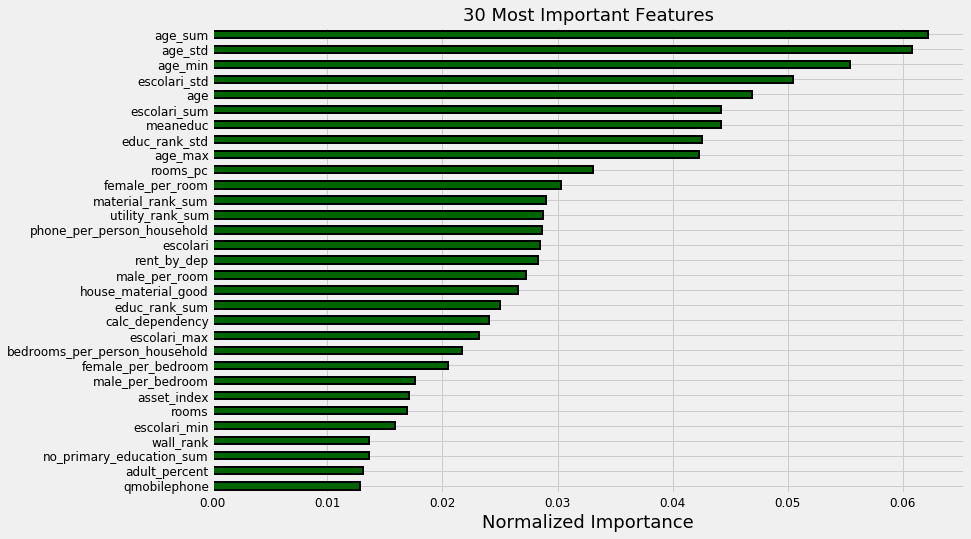

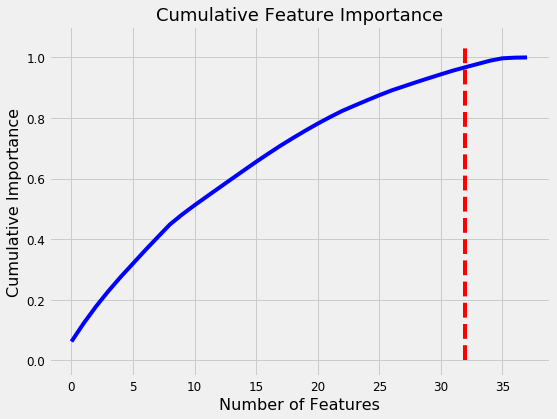

32 features required for 95% of cumulative importance.


In [60]:
plot_feature_importances(feature_importances, n=30, threshold=0.95)

In [61]:
%%time
cv_score = cross_val_score(model, train_X, train_y, cv=kfold, scoring=f1_scorer, n_jobs=-1, fit_params=fit_params)
print(f'Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

Cross Validation F1 Score = 0.4152 with std = 0.0078
Wall time: 6.32 s


Wall time: 47min 34s


<module 'matplotlib.pyplot' from 'c:\\users\\zrankin\\appdata\\local\\continuum\\miniconda3\\envs\\kaggle\\lib\\site-packages\\matplotlib\\pyplot.py'>

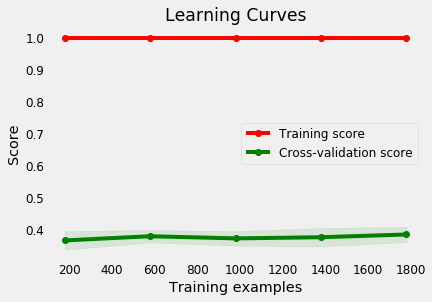

In [62]:
%%time
plot_learning_curve(model, 'Learning Curves', train_X, train_y, cv=kfold, scoring=f1_scorer)

## Submission 
(note that this is a kernels-only Kaggle competition)

In [ ]:
y_pred = model.predict(X_test_transformed)

In [ ]:
y_pred_series = pd.Series(y_pred, name = 'Target')
submission = pd.concat([X_test['Id'], y_pred_series], axis=1)
submission.to_csv('../submission.csv', index=None)

In [ ]:
submission.to_csv('../submission.csv', index=None)